# Forward applications

By David Ortiz and Rodrigo Salas, 2024

## Activity overview

In this activity, we will code a PINN for the solution of a linear diffusion model. 

## Activity goals

By the end of this activity, you should be able to:

 - define test PDE problems with custom analytical solutions
 - train PINN to solve PDE models


## Mathematical description of the problem
In this activity, we will consider the one dimensional diffusion model, usually called 1D heat equation,
$$
\begin{alignat*}{3}
    \frac{\partial u}{\partial t} &&= \kappa\frac{\partial^2 u}{\partial x^2} + f(t,x), \quad && x \in [-1, 1], \quad t \in [0, 1]. \quad \kappa\in\mathbb{R} \\
\end{alignat*}
$$

where $u(t,x)$ is the quantity of interest (e.g., temperature, concentration) at the point $x\in[-1,1]$ and at time $t\in[0,1]$, $\kappa$ is the diffusion coefficient, and $f(t,x)$ is a source term.

Here, we will fabricate our oun model. Thus, we propose as analytic function
$$
u(t,x) = e^{-t}\sin(\pi x)
$$

By deriving and replacing in the PDE, we obtain the following problem with initial and boundary conditions

$$
\begin{alignat*}{3}
    \text{PDE:} \quad & \frac{\partial u}{\partial t} &&= \kappa\frac{\partial^2 u}{\partial x^2} - e^{-t}(\sin(\pi x) - \pi^2\sin(\pi x)), \quad && x \in [-1, 1], \quad t \in [0, 1]. \quad \kappa\in\mathbb{R} \\
    \text{IC:} \quad & u(0,x) &&= \sin(\pi x), && x \in [-1, 1] \\
    \text{BC:} \quad & u(t,-1)&& = u(t,1)= 0, && t \in [0, 1] \\
    \text{Solution:} \quad & u(t,x) &&= e^{-t} \sin(\pi x)
\end{alignat*}
$$

Without loss of generality, we will assume $\kappa = 1$ for this activity.

## Initial setup

We begin by importing some usefull packages, and defining some functions

In [1]:
# Import NumPy for numerical operations
import numpy as np
# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim
# Import Matplotlib for plotting
import matplotlib.pyplot as plt
# Import a utility module 
import utils 
# Import the time module to time our training process
import time
# Ignore Warning Messages
import warnings
warnings.filterwarnings("ignore")

# torch definition of pi number
torch.pi = torch.acos(torch.zeros(1)).item() * 2


# Function to calculate the relative l2 error
def relative_l2_error(u_num, u_ref):
    # Calculate the L2 norm of the difference
    l2_diff = torch.norm(u_num - u_ref, p=2)
    
    # Calculate the L2 norm of the reference
    l2_ref = torch.norm(u_ref, p=2)
    
    # Calculate L2 relative error
    relative_l2 = l2_diff / l2_ref
    return relative_l2


# Function to plot the solutions
def plot_comparison(u_true, u_pred, loss):
    
    # Convert tensors to numpy arrays for plotting
    u_pred_np = u_pred.detach().numpy()

    # Create a figure with 4 subplots
    fig1, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot the true values
    im1 = axs[0].imshow(u_true, extent=[-1,1,1,0])
    axs[0].set_title('Analytic solution for diffusion')
    axs[0].set_xlabel(r'$x$')
    axs[0].set_ylabel(r'$t$')
    fig1.colorbar(im1, spacing='proportional',
                            shrink=0.5, ax=axs[0])

    # Plot the predicted values
    im2 = axs[1].imshow(u_pred_np, extent=[-1,1,1,0])
    axs[1].set_title('PINN solution for diffusion')
    axs[1].set_xlabel(r'$x$')
    axs[1].set_ylabel(r'$t$')
    fig1.colorbar(im2, spacing='proportional',
                            shrink=0.5, ax=axs[1])
        # Display the plot
    plt.tight_layout()
    plt.show()


    # Plot the loss values recorded during training
    # Create a figure with  subplots
    fig2, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Plot the difference between the predicted and true values
    difference = np.abs(u_true - u_pred_np)
    im3 = axs[0].imshow(difference, extent=[-1,1,1,0])
    axs[0].set_title(r'$|u(t,x) - u_{pred}(t,x)|$')
    axs[0].set_xlabel(r'$x$')
    axs[0].set_ylabel(r'$t$') 
    fig2.colorbar(im3, spacing='proportional',
                            shrink=0.5, ax=axs[0])
    
    axs[1].plot(loss)
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Loss')
    axs[1].set_yscale('log')
    axs[1].set_xscale('log')
    axs[1].set_title('Training Progress')
    axs[1].grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()
    

def grad(outputs, inputs):
    """Computes the partial derivative of an output with respect 
    to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs, 
                        grad_outputs=torch.ones_like(outputs), 
                        create_graph=True,
                        retain_graph=True,  
                        )[0]

### Analytical solution
We define the analytical solution $u(t,x) = e^{-t}\sin(\pi x)$ for the diffusion problem 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


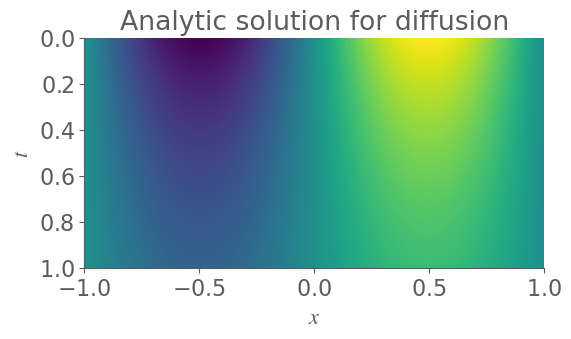

In [2]:
# Number of samples in x and t
dom_samples = 100

# Function for the diffusion analytical solution
def analytic_diffusion(x,t):
    u = np.exp(-t)*np.sin(np.pi*x)
    return u

# spatial domain
x = np.linspace(-1, 1, dom_samples)
# temporal domain
t = np.linspace(0, 1, dom_samples)

# Domain mesh
X, T = np.meshgrid(x, t)
U = analytic_diffusion(X, T)

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(U, extent=[-1,1,1,0])
ax.set_title('Analytic solution for diffusion')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$') 
ax.legend(loc='lower left', frameon=False)
plt.tight_layout()
plt.show()

## Training the Physics-informed Neural Network
To train the PINN, we will generate the domain using the `LatinHypercube` sampling (LHS) strategy. LHS ensures that the samples evenly cover the input space ensuring that the samples are not clustered in a small area, but are distributed over the entire space. 

We import the `qmc.LatinHypercube` from `scipy.stats` and scale it to the boundaries of the domain. Also, we convert the temporal domain and the observations to `torch.tensors`

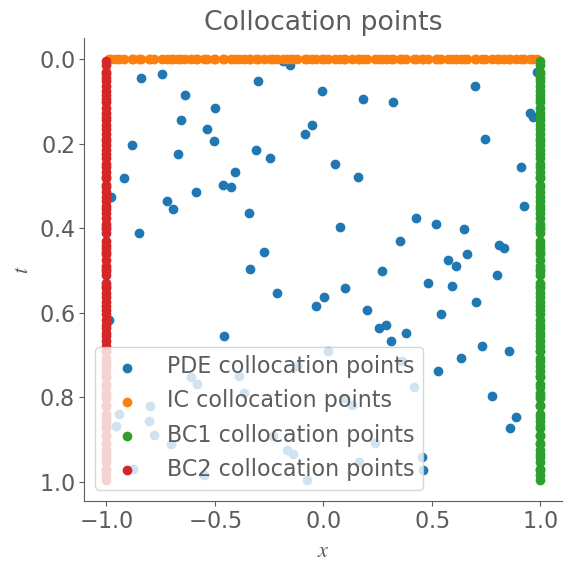

In [3]:
from scipy.stats import qmc
# LHS sampling strategy
sampler = qmc.LatinHypercube(d=2)
sample = sampler.random(n=100)

# lower and upper boundas of the domain
l_bounds = [-1, 0]
u_bounds = [ 1, 1]
domain_xt = qmc.scale(sample, l_bounds, u_bounds)

# torch tensors
x_ten = torch.tensor(domain_xt[:, 0], requires_grad = True).float().reshape(-1,1)
t_ten = torch.tensor(domain_xt[:, 1], requires_grad = True).float().reshape(-1,1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(domain_xt[:, 0],domain_xt[:, 1], label = 'PDE collocation points')
ax.scatter(domain_xt[:, 0],np.zeros_like(domain_xt[:, 1]), label = 'IC collocation points')
ax.scatter(np.ones_like(domain_xt[:, 0]),domain_xt[:, 1], label = 'BC1 collocation points')
ax.scatter(np.ones_like(domain_xt[:, 1])*-1,domain_xt[:, 1], label = 'BC2 collocation points')
ax.set_title('Collocation points')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$t$') 
ax.legend(loc='lower left')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

We train the artificial neural network to directly approximate the solution to the partial differential equation, i.e.,

$$
u_{PINN}(t, x; \Theta) \approx u(t,x)
$$

where $\Theta$ are the free (trainable) parameters of the ANN. Now, we use `PyTorch` and define the neural network and, for this task, we will use the ADAM optimizer.

In [4]:
torch.manual_seed(123)

# training parameters
hidden_layers = [2, 10, 10, 10, 1]
learning_rate = 0.001
training_iter = 20000

In [5]:
# Define a loss function (Mean Squared Error) for training the network
MSE_func = nn.MSELoss()

# Define a neural network class with user defined layers and neurons
class NeuralNetwork(nn.Module):
    
    def __init__(self, hlayers):
        super(NeuralNetwork, self).__init__()
        
        layers = []
        for i in range(len(hlayers[:-2])):
            layers.append(nn.Linear(hlayers[i], hlayers[i+1]))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hlayers[-2], hlayers[-1]))
        
        self.layers = nn.Sequential(*layers)
        self.init_params
        
    def init_params(self):
        """Xavier Glorot parameter initialization of the Neural Network
        """
        def init_normal(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) # Xavier
        self.apply(init_normal)

    def forward(self, x):
        return self.layers(x)

In [6]:
# Create an instance of the neural network 
u_pinn = NeuralNetwork(hidden_layers)
nparams = sum(p.numel() for p in u_pinn.parameters() if p.requires_grad)
print(f'Number of trainable parameters: {nparams}')

# Define an optimizer (Adam) for training the network
optimizer = optim.Adam(u_pinn.parameters(), lr=0.001, 
                       betas= (0.9,0.999), eps = 1e-8)

Number of trainable parameters: 261


### Physics-Informed Loss function
To train the PINN, we recall the diffusion model and define function $f_{pde}(t, x)$, $g_{ic}(0)$ and $h_{bc}(0)$ for the PDE, the initial condition and the boundary condition. Also, we replace the analytical solution $u(t,x)$ with the PINN output $u_{pinn}(t,x; \Theta)$:

$$
\begin{align*}
f_{pde}(t,x;u_{pinn}):=& \frac{\partial u}{\partial t} - \frac{\partial^2 y}{\partial x^2} + e^{-t}(\sin(\pi x) - \pi^2 \sin(\pi x)) = 0\\
g_{ic}(0,x;u_{pinn}):=&u_{pinn}(0,x; \Theta) = \sin(\pi x)\\
h_{bc1}(t,-1;u_{pinn}):=&u_{pinn}(t,-1; \Theta) = 0\\
h_{bc2}(t,1;u_{pinn}):=&u_{pinn}(t,1; \Theta) = 0
\end{align*}
$$

Once again we use the $MSE$ and define the physics-informed loss function:

$$
\begin{align*}
\mathcal{L}(\theta):&= \frac{\lambda_1}{N}\sum_i\left(f_{pde}(t_i, x_i;u_{pinn})-0\right)^2 \quad \text{PDE loss}\\
                   & + \frac{\lambda_2}{N} \sum_i(g_{ic}(0,x_i;u_{pinn})-\sin(\pi x_i))^2 \quad \text{IC loss}\\
                   & + \frac{\lambda_3}{N} \sum_i(h_{bc1}(t_i,-1;u_{pinn})-0)^2 \quad \text{BC1 loss}\\
                   & + \frac{\lambda_3}{N} \sum_i(h_{bc2}(t_i,1;u_{pinn})-0)^2 \quad \text{BC2 loss}\\
\end{align*}
$$

where $\lambda_{1,2,3}\in\mathbb{R}^+$ are positive (weigth) numbers, and $N$ is the number of samples. 

<div class="alert alert-info"
    style="background-color:#5c5c5c;color:#000000;border-color:#000000">
  <strong>REMARK!</strong> when we do not include the loss function related to the data, we are employing a data-free scheme; when we include the data, we are employing a data-driven scheme.
</div>

The training is performed by minimizing the loss function $\mathcal{L}(\Theta)$, i.e.,

$$
\min_{\Theta\in\mathbb{R}} \mathcal{L}(\Theta)\rightarrow 0
$$

<div class="alert alert-info"
    style="background-color:#5c5c5c;color:#000000;border-color:#000000">
  <strong>REMARK!</strong> Autodifferentiation (torch.autograd) is a powerful tool for calculating the gradients of the PINN with respect to its input to evaluate the loss function; for more information, refer to the tutorial.
</div>



In [7]:
# HINT: 
def PINN_diffusion_Loss(forward_pass, x_ten, t_ten, 
             lambda1 = 1, lambda2 = 1, lambda3 = 1):

    # ANN output, first and second derivatives
    domain = torch.cat([t_ten, x_ten], dim = 1)
    u = forward_pass(domain)
    u_t = grad(u, t_ten)
    u_x = grad(u, x_ten)
    u_xx = grad(u_x, x_ten)
    
    # PDE loss definition
    f_pde = u_t - u_xx + torch.exp(-t_ten)*(torch.sin(np.pi*x_ten)
                          -(torch.pi**2)*torch.sin(np.pi*x_ten))
    PDE_loss = lambda1 * MSE_func(f_pde, torch.zeros_like(f_pde)) 
    
    # IC loss definition
    ic = torch.cat([torch.zeros_like(t_ten), x_ten], dim = 1)
    g_ic = forward_pass(ic)
    IC_loss = lambda2 * MSE_func(g_ic, torch.sin(torch.pi*x_ten))

    # BC x = -1 definition
    bc1 = torch.cat([t_ten, -torch.ones_like(x_ten)], dim = 1)
    h_bc1 = forward_pass(bc1)
    BC1_loss = lambda3 * MSE_func(h_bc1, torch.zeros_like(h_bc1))
    
    # BC x = 1 definition
    bc2 = torch.cat([t_ten, torch.ones_like(x_ten)], dim = 1)
    h_bc2 = forward_pass(bc2)
    BC2_loss = lambda3 * MSE_func(h_bc2, torch.zeros_like(h_bc2))
    
    return PDE_loss + IC_loss + BC1_loss + BC2_loss
    
# Initialize a list to store the loss values
loss_values = []

# Start the timer
start_time = time.time()

# Training the neural network
for i in range(training_iter):
    
    optimizer.zero_grad()   # clear gradients for next train

    # input x and predict based on x
    loss = PINN_diffusion_Loss(u_pinn, x_ten, t_ten)
    
    # Append the current loss value to the list
    loss_values.append(loss.item())
    
    if i % 1000 == 0:  # print every 100 iterations
        print(f"Iteration {i}: Loss {loss.item()}")
    
    loss.backward() # compute gradients (backpropagation)
    optimizer.step() # update the ANN weigths

# Stop the timer and calculate the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time} seconds")

Iteration 0: Loss 17.226625442504883
Iteration 1000: Loss 0.04277494549751282
Iteration 2000: Loss 0.012269478291273117
Iteration 3000: Loss 0.00491524301469326
Iteration 4000: Loss 0.0018975319107994437
Iteration 5000: Loss 0.0010208941530436277
Iteration 6000: Loss 0.0005992661463096738
Iteration 7000: Loss 0.0003400975838303566
Iteration 8000: Loss 0.00016440688341390342
Iteration 9000: Loss 9.469420911045745e-05
Iteration 10000: Loss 7.097123307175934e-05
Iteration 11000: Loss 5.5616674217162654e-05
Iteration 12000: Loss 4.7684334276709706e-05
Iteration 13000: Loss 4.123433609493077e-05
Iteration 14000: Loss 5.424873234005645e-05
Iteration 15000: Loss 3.3437987440265715e-05
Iteration 16000: Loss 6.695042975479737e-05
Iteration 17000: Loss 2.8681923140538856e-05
Iteration 18000: Loss 3.0282395528047346e-05
Iteration 19000: Loss 2.5436100258957595e-05
Training time: 31.666361093521118 seconds


Relative error: 0.002208635676652193


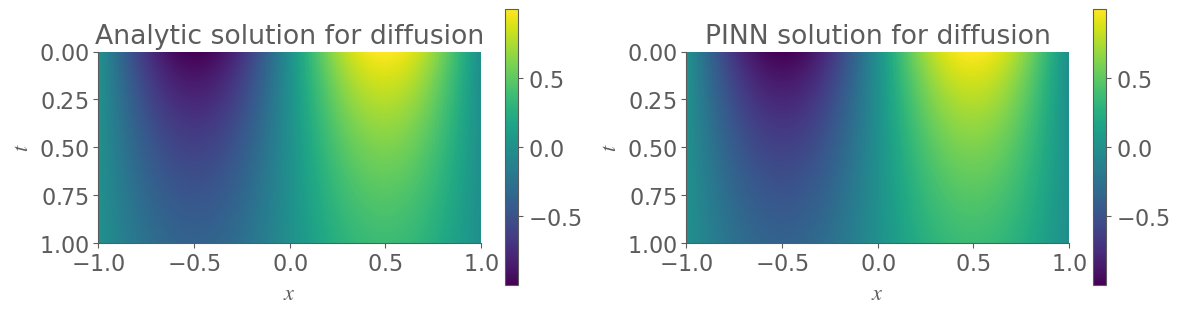

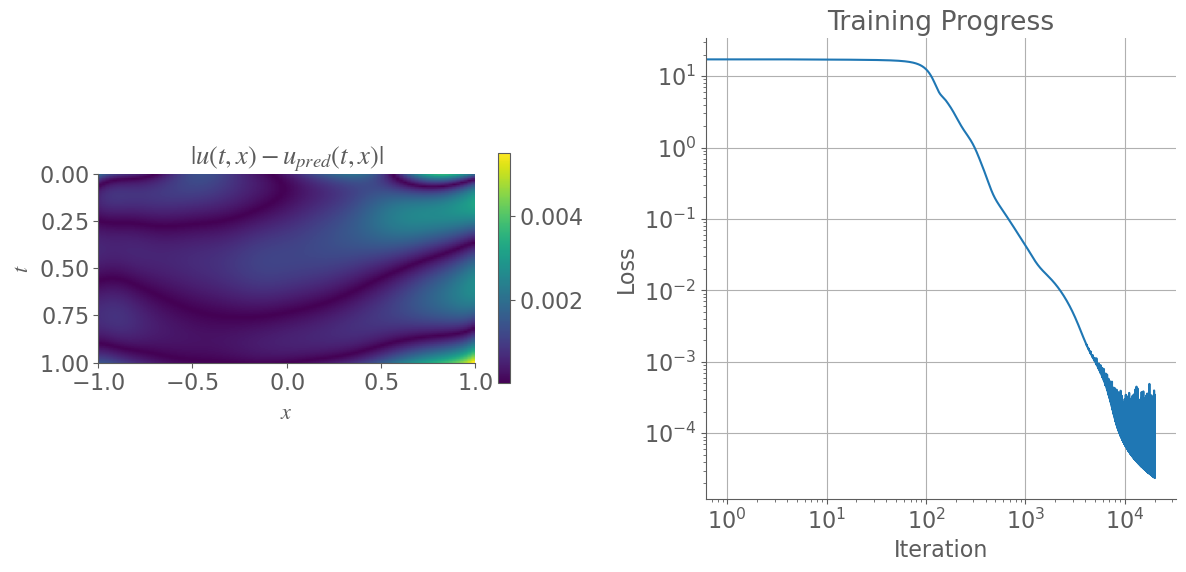

In [8]:

X_ten = torch.tensor(X).float().reshape(-1, 1)
T_ten = torch.tensor(T).float().reshape(-1, 1)
domain_ten = torch.cat([T_ten, X_ten], dim = 1)
U_pred = u_pinn(domain_ten).reshape(dom_samples,dom_samples)

U_true = torch.tensor(U).float()
print(f'Relative error: {relative_l2_error(U_pred, U_true)}')

plot_comparison(U, U_pred, loss_values)

**Exercise**:
1. Add the data driven-case. **HINT**: you must use the same collocation points for the analytic function and the PINN
2. increase and decrease the `lambdas` parameters of the loss function
3. increase and reduce the learning rate of the optimizer
4. change the architecture of the ANN
5. increase the number of training iterations
6. discuss about convergence rate and the relative error. What do you notice compared to the non-linear exmple in activity 1